In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.signal import savgol_filter, find_peaks
import regex as re
import itertools
import json
import pandas as pd

In [2]:
#Crit from each possible item
itemCrit=[0,15,20]

#Possible crit values
critValues=sorted(set(map(sum,itertools.product(*[itemCrit]*5))))

#Remove 0% and 100%
critValues=critValues[1:-1]
critValues

[15, 20, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [3]:
#Read all files and obtain the binary strings

def wav2critString(audio0,audio1):
    #Reads peaks from both samples and sorts the peaks

    #First find the running average to smooth peaks, width=0.1s or 0.1s*2000hz=200 samples
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    norm0=moving_average(np.abs(audio0),201)
    norm1=moving_average(np.abs(audio1),201)

    #Smooth double peaks
    smooth0=savgol_filter(norm0, window_length = 201, polyorder = 5)
    smooth1=savgol_filter(norm1, window_length = 201, polyorder = 5)

    #Find peaks
    peaks0,_= find_peaks(smooth0,height=500)
    peaks1,_= find_peaks(smooth1,height=500)

    #And sort them to get the crit sequence
    peaks0={(x,0) for x in peaks0}
    peaks1={(x,1) for x in peaks1}

    allPeaks=list(peaks0|peaks1)
    allPeaks.sort(key=lambda x:x[0])

    crits=''.join([str(x) for _,x in allPeaks])

    return crits


critStrings={}
for critValue in critValues:
    #Rates are 2000hz
    rate0, data0 = wavfile.read('./data/'+str(critValue)+'_0.wav')
    rate1, data1 = wavfile.read('./data/'+str(critValue)+'_1.wav')

    critStrings[critValue]=wav2critString(data0,data1)


In [4]:
#Save to JSON
with open('./data/critSeq.json','w') as fp:
    json.dump(critStrings,fp)

In [5]:
#Or load it
with open('./data/critSeq.json','r') as fp:
    critStrings=json.load(fp)
    critStrings={int(k):v for k,v in critStrings.items()}

In [6]:
#Utility function to compute probability to obtain a crit sequence after an initial crit sequence
def critChance(string,seq,result='1'):
    seqCount=len(re.findall(seq,string,overlapped=True))
    resCount=len(re.findall(seq+result,string,overlapped=True))
    return resCount/seqCount*100


def critChanceSet(strSet,seq,result='1'):
    return {k:critChance(v,seq,result) for k,v in strSet.items()}

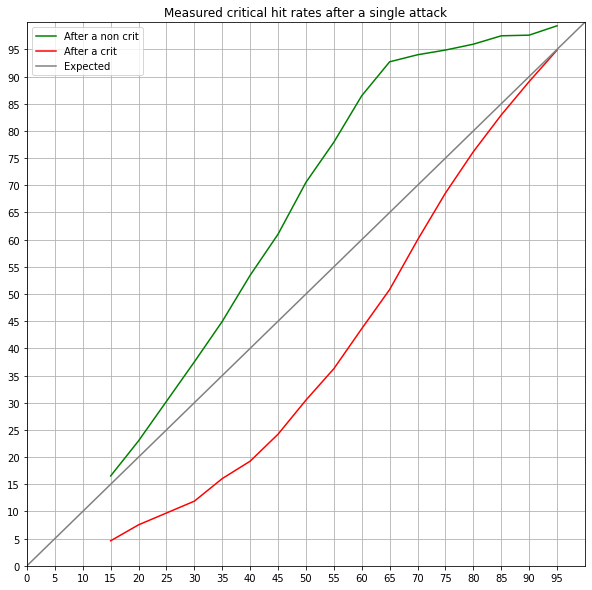

In [30]:
#Plot nominal crit rates vs real rates after a non crit and a crit

from cProfile import label
from turtle import color


after0=critChanceSet(critStrings,'0')
after1=critChanceSet(critStrings,'1')

plt.figure(figsize=(10,10))
plt.xlim(0,100)
plt.ylim(0,100)
plt.grid(True,'both')
plt.plot(after0.keys(),after0.values(),color='green',label="After a non crit")
plt.plot(after1.keys(),after1.values(),color='red',label="After a crit")
plt.plot([0,100],[0,100], color='grey',label="Expected")
plt.xticks(range(0,100,5))
plt.yticks(range(0,100,5))
plt.title("Measured critical hit rates after a single attack")
plt.legend();